In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl

%matplotlib inline
import matplotlib
import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioData
from src import utils

### 1. Load the speech file speech1.wav.

In [2]:
speech = AudioData(os.path.join(os.getcwd(), '../Exercise3', 'AudioFiles', 'speech1.wav'))

Successfully loaded audio data from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise3/AudioFiles/speech1.wav


### 2. Select one unvoiced and one voiced speech segment from the signal, each with a length of 32 ms.

In [3]:
frame_centers_ms, frames = speech.get_frames(32, 32)

In [4]:
hann = ss.get_window('hann', utils.ms_to_idx(32, 16000))

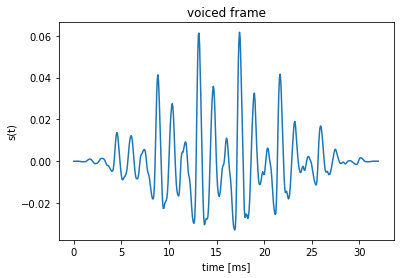

In [5]:
voiced_frame_idx = 13 # np.where(frame_centers_ms == 400)[0][0]
voiced_frame = frames[voiced_frame_idx] * hann

t = np.linspace(0, 32, 512)
fix, ax = plt.subplots()
ax.set_title("voiced frame")
ax.set_xlabel("time [ms]")
ax.set_ylabel("s(t)")
ax.plot(t, voiced_frame)

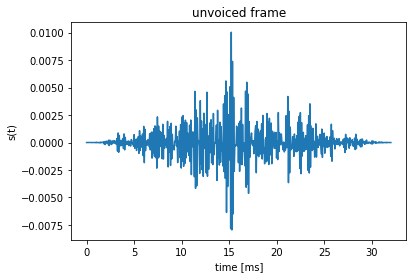

In [6]:
unvoiced_frame_idx = np.where(frame_centers_ms == 560)[0][0]
unvoiced_frame = frames[unvoiced_frame_idx] * hann

t = np.linspace(0, 32, 512)
fix, ax = plt.subplots()
ax.set_title("unvoiced frame")
ax.set_xlabel("time [ms]")
ax.set_ylabel("s(t)")
ax.plot(t, unvoiced_frame)

### 3. Compute the M = 12-order LP coefficients

In [98]:
def auto_correlate(frame:np.array):
    return np.correlate(frame, frame,'full')


def compute_phi(frame: np.array, m:int =12):
    acf = auto_correlate(frame)
    phi_start = len(acf) // 2
    phi_end = phi_start + m
    phi = acf[phi_start:phi_end + 1]
    assert len(phi) == m+1, f"len(phi)={len(phi)} != m+1={m+1}"
    return phi

def compute_lpc(frame: np.array, m:int=12):
    phi = compute_phi(frame, m)
    c = phi[:-1]
    r = phi[:-1]
    b = phi[1:]
    a = sl.solve_toeplitz((c,r), b)
    assert len(a) == m
    return a 

In [91]:
lpc_voiced = compute_lpc(voiced_frame, m=12)
lpc_unvoiced = compute_lpc(unvoiced_frame, m=12)

### 4. a) Make a plot of the frequency response (amplitude as well as phase) of the estimated vocal tract filter

In [92]:
def compute_complex_filter_response(lpc: np.array, n:int=512, fs:int=16000):
    return ss.freqz(1, np.concatenate(([1], lpc)), n, whole=True, fs=fs)

In [93]:
fresp_voiced = compute_complex_filter_response(lpc_voiced, len(voiced_frame), speech.sampling_freq)
fresp_unvoiced = compute_complex_filter_response(lpc_unvoiced, len(unvoiced_frame), speech.sampling_freq)

In [94]:
def plot_filter_response(fresp, frame_name:str = None):
    w, h = fresp
    fig, ax1 = plt.subplots( figsize=(10, 5))
    ax1.set_title('Digital filter frequency response: %s' % frame_name)
    ax1.plot(w, 10 * np.log10(np.abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [Hz]')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

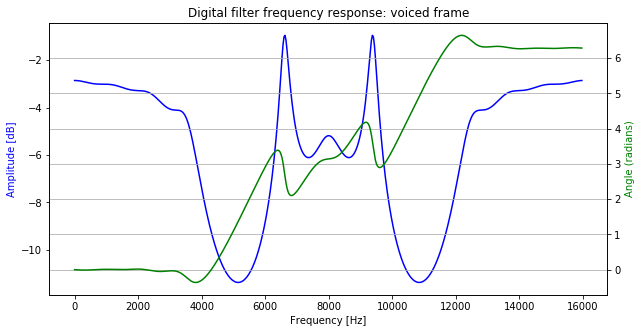

In [95]:
plot_filter_response(fresp_voiced, "voiced frame")

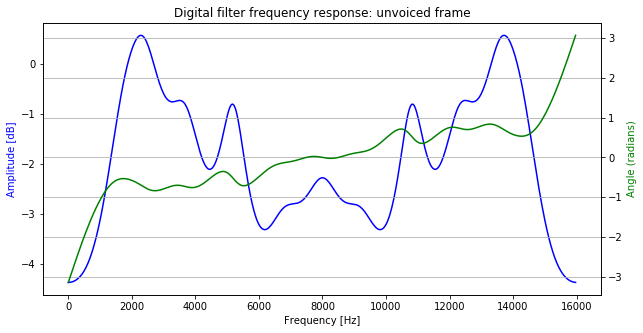

In [96]:
plot_filter_response(fresp_unvoiced, "unvoiced frame")

### 5. Compute the discrete Fourier transform (DFT) of the windowed segments

In [86]:
dft_voiced = np.fft.rfft(voiced_frame)
dft_unvoiced = np.fft.rfft(unvoiced_frame)

(512,)
(512,)
(257,)


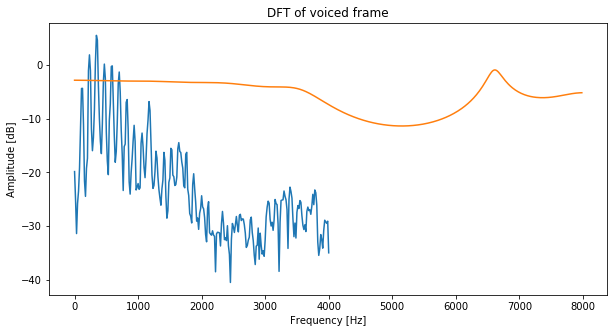

In [88]:
w, h = fresp_voiced

print(w.shape)
print(h.shape)
print(dft_voiced.shape)

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_title('DFT of voiced frame')
# freq = np.fft.rfftfreq(512, d=1./speech.sampling_freq)
ax1.plot(w[:dft_voiced.shape[0]], 10 * np.log10(np.abs(dft_voiced)))
ax1.set_ylabel('Amplitude [dB]')
ax1.set_xlabel('Frequency [Hz]')


ax1.plot(w, 10 * np.log10(np.abs(h)))